<h1 align=center><font size = 5>Segmenting and Clustering Community Areas in Chicago</font></h1>

## Introduction
In this notebook we will segment and cluster community areas in the city of chicago based on Population Denisity per Square Mile, Per Capita Income, Count of Crimes, Count of Restaurants and Count of Parking. We will then analyze the clusters to identify suitable cluster of community areas for opening a restaurant. A cluster will be suitable for opening a restaurant with higher Population Denisity per Square Mile, Per Capita Income, Count of Parkings, and lower Count of Crimes and Count of Restaurants. To do this analyses we will first need to obtain data from relevant sources and process the data to be in shape and form relevant to our analysis. 

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item4">Cluster Neighborhoods</a>
    
3. <a href="#item4">Visualize Clusters Using Folium Map</a>  

4. <a href="#item5">Examine Clusters Using Box and Scatter Plots</a>    
</font>
</div>

Before we start, we will download and import the required dependencies

In [3]:
# Install and import liabraries for webscrapping
!pip install beautifulsoup4 
from bs4 import BeautifulSoup

# Install liabrary for parsing html
!pip install html5lib

# Install and import map rendering liabrary
!pip install folium
import folium

# Install and import liabrary for converting location addresses to latitude and longitude values
!pip install geopy 
from geopy.geocoders import Nominatim

import requests # import liabraries for handling requests
import pandas as pd # # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files
import csv # liabrary for reading and writing csv files
import matplotlib
import matplotlib.pyplot as plt

# Import StandardScaler and KMeans clustering 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

print('Liabraries installed and imported successfully.')

     |████████████████████████████████| 122kB 4.9MB/s eta 0:00:01
     |████████████████████████████████| 122kB 8.7MB/s eta 0:00:01
Liabraries installed and imported successfully.


## 1. Download and Explore the Datasets

In [4]:
#Get Chicago crime data for the year 2019
!wget -q -O 'Chicago Crime Data.csv' https://data.cityofchicago.org/api/views/w98m-zvie/rows.csv?accessType=DOWNLOAD
    
#Census Data - Selected socioeconomic indicators in Chicago, 2008 – 2012
!wget -q -O 'Chicago Socioeconomic Indicators.csv' https://data.cityofchicago.org/api/views/kn9c-c2s2/rows.csv?accessType=DOWNLOAD


In [15]:
df_crime = pd.read_csv('Chicago Crime Data.csv')
df_crime.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12065603,JD249713,11/16/2019 09:00:00 AM,066XX N GREENVIEW AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,49.0,1,11,NaN,NaN,2019,06/02/2020 03:49:38 PM,NaN,NaN,NaN
1,12065347,JD249752,09/29/2019 03:39:00 PM,003XX S CAMPBELL AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,APARTMENT,False,False,...,27.0,28,11,NaN,NaN,2019,06/02/2020 03:49:38 PM,NaN,NaN,NaN
2,12065660,JD250095,04/11/2019 12:01:00 AM,0000X E MADISON ST,1122,DECEPTIVE PRACTICE,COUNTERFEIT CHECK,BANK,False,False,...,42.0,32,10,NaN,NaN,2019,06/02/2020 03:49:38 PM,NaN,NaN,NaN
3,12065556,JD249911,05/31/2019 12:01:00 AM,049XX W NORTH AVE,0610,BURGLARY,FORCIBLE ENTRY,BANK,False,False,...,37.0,25,05,NaN,NaN,2019,06/02/2020 03:49:38 PM,NaN,NaN,NaN
4,11923749,JC549409,05/22/2019 11:40:00 PM,003XX N WABASH AVE,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL / MOTEL,False,False,...,42.0,8,02,1176556.0,1902666.0,2019,06/02/2020 03:47:30 PM,41.888267,-87.627075,"(41.888267493, -87.627075047)"


In [16]:
df_socio = pd.read_csv('Chicago Socioeconomic Indicators.csv')
df_socio.head()

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [17]:
# Download Chicago neigborhood data from wikipedia and store it in a dataframe
url = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago'
result = requests.get(url).text

soup = BeautifulSoup(result, 'html5lib').find('table')
tr = soup.find_all('tr')

col = ['Community Area Name', 'Neighborhood']
chicago_communities = []
chicago_neighborhoods = []

# Chicago communities and neighborhoods are located at indices 1 and 3 of list 'tr'
for row in tr:
    temp = row.text.split('\n')
    chicago_neighborhoods.append(temp[1])
    chicago_communities.append(temp[3])

df_neighborhoods = pd.DataFrame([chicago_communities[1:], chicago_neighborhoods[1:]]).T
df_neighborhoods.columns = col
df_neighborhoods.head()

,Community Area Name,Neighborhood
0,Albany Park,Albany Park
1,Riverdale,Altgeld Gardens
2,Edgewater,Andersonville
3,Archer Heights,Archer Heights
4,Armour Square,Armour Square


In [18]:
# Download Chicago census data 2017 from wikipedia and store it in a dataframe
url = 'https://en.wikipedia.org/wiki/Community_areas_in_Chicago'
result = requests.get(url).text

soup = BeautifulSoup(result, 'html5lib').find('table')
tr = soup.find_all('tr')

col = ['Community Area Number', 'Community Area Name', 'Population', 'Area (Sq./Mile)', 'Population Density (Sq./Mile)']

community_num = []
communities = []
population = []
area = []
density = []

# Chicago communities number, name, population, area and density data are located at indices 1, 3, 5, 7 and 11 of list 'tr'
for row in tr:
    temp = row.text.split('\n')
    community_num.append(temp[1])
    communities.append(temp[3])
    population.append(temp[5])
    area.append(temp[7])
    density.append(temp[11])
    
# Remove the first and last elements from the lists as they are not relevant
length = len(community_num)-1
community_num = community_num[1:length]
communities = communities[1:length]
population = population[1:length]
area = area[1:length]
density = density[1:length]

# Remove commas from numbers and Convert to integer
population = [int(i.replace(',', '')) for i in population]
community_num = list(map(int, community_num))

# Remove commas from numbers and Convert to float
area = [float(i.replace(',', '')) for i in area]
density = [float(i.replace(',', '')) for i in density]

# Create a dataframe for the lists.
df_census = pd.DataFrame([community_num, communities, population, area, density]).T
df_census.columns = col
df_census.set_index('Community Area Number', drop=True, inplace=True)
df_census.head()

,Community Area Name,Population,Area (Sq./Mile),Population Density (Sq./Mile)
Community Area Number,,,,
1,Rogers Park,55062,1.84,29925
2,West Ridge,76215,3.53,21590.7
3,Uptown,57973,2.32,24988.4
4,Lincoln Square,41715,2.56,16294.9
5,North Center,35789,2.05,17458


Merge the nighborhoods by community area name and store it in df_neighborhoods

In [19]:
df_neighborhoods = df_neighborhoods.groupby('Community Area Name')['Neighborhood'].apply(lambda x: ', '.join(x)).to_frame()
df_neighborhoods.reset_index(inplace=True)
print(df_neighborhoods.shape)
df_neighborhoods.head()

(82, 2)


,Community Area Name,Neighborhood
0,Albany Park,"Albany Park, Mayfair, North Mayfair, Ravenswoo..."
1,Archer Heights,Archer Heights
2,Armour Square,"Armour Square, Chinatown, Wentworth Gardens"
3,Ashburn,"Ashburn, Ashburn Estates, Beverly View, Crestl..."
4,Auburn Gresham,"Auburn Gresham, Gresham"


Let's merge the cenus dataframe with neighborhood dataframe and store it in dataframe df_merged

In [20]:
df_merged = df_census.merge(df_neighborhoods, on='Community Area Name', how='left')
df_merged.set_index(df_census.index, inplace=True)
print(df_merged.shape)
df_merged.head()

(77, 5)


,Community Area Name,Population,Area (Sq./Mile),Population Density (Sq./Mile),Neighborhood
Community Area Number,,,,,
1,Rogers Park,55062,1.84,29925,"Loyola, Rogers Park"
2,West Ridge,76215,3.53,21590.7,"Nortown, Peterson Park, Rosehill, West Ridge, ..."
3,Uptown,57973,2.32,24988.4,"Buena Park, Clarendon Park, Margate Park, New ..."
4,Lincoln Square,41715,2.56,16294.9,"Bowmanville, Budlong Woods, Lincoln Square, Ra..."
5,North Center,35789,2.05,17458,"North Center, Roscoe Village, Saint Ben's"


Let's just retain the community area number and per capital income of df_socio add it to our merged dataframe df_merged

In [21]:
col = [0,7]
df_socio = df_socio.iloc[:,col]
df_socio.set_index('Community Area Number', drop=True, inplace=True)

# Merge df_socio with our df_merged
df_socio.columns =['Per Capita Income']
df_merged = df_merged.merge(df_socio, left_index=True, right_index=True)
df_merged.set_index(df_merged.index.astype(int), inplace=True)
print(df_merged.shape)
df_merged.head()

(77, 6)


,Community Area Name,Population,Area (Sq./Mile),Population Density (Sq./Mile),Neighborhood,Per Capita Income
Community Area Number,,,,,,
1,Rogers Park,55062,1.84,29925,"Loyola, Rogers Park",23939
2,West Ridge,76215,3.53,21590.7,"Nortown, Peterson Park, Rosehill, West Ridge, ...",23040
3,Uptown,57973,2.32,24988.4,"Buena Park, Clarendon Park, Margate Park, New ...",35787
4,Lincoln Square,41715,2.56,16294.9,"Bowmanville, Budlong Woods, Lincoln Square, Ra...",37524
5,North Center,35789,2.05,17458,"North Center, Roscoe Village, Saint Ben's",57123


Lets count the number of crimes committed in each community area and add it to the merged dataframe

In [22]:
df_crime_count = pd.DataFrame(df_crime['Community Area'].value_counts())
df_crime_count.columns = ['Count of Crimes']
df_crime_count.index.rename('Community Area Number', inplace=True)

# Let's merge the crime percentage with with the merged dataframe.
df_merged = df_merged.merge(df_crime_count, left_index=True, right_index=True)
df_merged

,Community Area Name,Population,Area (Sq./Mile),Population Density (Sq./Mile),Neighborhood,Per Capita Income,Count of Crimes
Community Area Number,,,,,,,
1,Rogers Park,55062,1.84,29925,"Loyola, Rogers Park",23939,4035
2,West Ridge,76215,3.53,21590.7,"Nortown, Peterson Park, Rosehill, West Ridge, ...",23040,3441
3,Uptown,57973,2.32,24988.4,"Buena Park, Clarendon Park, Margate Park, New ...",35787,3339
4,Lincoln Square,41715,2.56,16294.9,"Bowmanville, Budlong Woods, Lincoln Square, Ra...",37524,1793
5,North Center,35789,2.05,17458,"North Center, Roscoe Village, Saint Ben's",57123,1270
...,...,...,...,...,...,...,...
73,Washington Heights,27453,2.86,9598.95,"Brainerd, Longwood Manor, Washington Heights",19713,3205
74,Mount Greenwood,19277,2.71,7113.28,"Mount Greenwood, Talley's Corner",34381,466
75,Morgan Park,22394,3.3,6786.06,"Beverly Woods, Kennedy Park, Morgan Park, West...",27149,1867


#### Let's get the coordinates of each community area and add it to the merged dataframe

In [23]:
# Let's get the latitude and longitude data for each community area
geolocator = Nominatim(user_agent='my_agent')
df_coordinates = pd.DataFrame()
df_coordinates['Latitude'] = np.nan
df_coordinates['Longitude'] = np.nan

i = 0
for community in df_merged['Community Area Name']:
    try:
        i = i+1
        community = str(community + ', Chicago')
        location = geolocator.geocode(community)
        df_coordinates.loc[i, 'Latitude'] = location.latitude
        df_coordinates.loc[i, 'Longitude'] = location.longitude
    except:
        # Assign np.nan to lat and lang if returned none by the location object
        df_coordinates.loc[i, 'Latitude'] = np.nan
        df_coordinates.loc[i, 'Longitude'] = np.nan
    
df_coordinates.head()

,Latitude,Longitude
1,42.010531,-87.670748
2,42.003548,-87.696243
3,41.966630,-87.655546
4,41.975990,-87.689616
5,41.956107,-87.679160


Let's check for any nan value in df_coordinates

In [24]:
print(df_coordinates.isnull().sum())

Latitude     1
Longitude    1
dtype: int64


It seems there is one community for which we have failed to get the location coordinates. Let's identify the community area number.

In [25]:
missing = df_coordinates[df_coordinates['Latitude'].isnull().values].index.values
missing

array([32])

In [26]:
# Let's check the community area name at index 32
print(df_merged.loc[32, 'Community Area Name'])

(The) Loop[11]


The name of the community is not properly written. Let's just try the name 'Loop' only to see if geopy can get the coordinates for this

In [27]:
loc = geolocator.geocode('Loop, Chicago')
print(loc.latitude, loc.longitude)

41.8755616 -87.6244212


 Add missing coordinates of the community area to df_coordinates and merge it with the merged dataframe

In [28]:
# Hurrah! we got the coordinates. Let's insert it into the coordinates dataframe
df_coordinates.loc[32,'Latitude'] = loc.latitude
df_coordinates.loc[32,'Longitude'] = loc.longitude

# Let's also change the name of the community to Loop and also add the neighborhood Loop
df_merged.loc[32, 'Community Area Name'] = 'Loop'
df_merged.loc[32, 'Neighborhood'] = 'Loop'

# Merge the df_coordinates with df_merged
df_merged = df_merged.merge(df_coordinates, left_index=True, right_index=True)
df_merged.head()

,Community Area Name,Population,Area (Sq./Mile),Population Density (Sq./Mile),Neighborhood,Per Capita Income,Count of Crimes,Latitude,Longitude
Community Area Number,,,,,,,,,
1,Rogers Park,55062,1.84,29925,"Loyola, Rogers Park",23939,4035,42.010531,-87.670748
2,West Ridge,76215,3.53,21590.7,"Nortown, Peterson Park, Rosehill, West Ridge, ...",23040,3441,42.003548,-87.696243
3,Uptown,57973,2.32,24988.4,"Buena Park, Clarendon Park, Margate Park, New ...",35787,3339,41.966630,-87.655546
4,Lincoln Square,41715,2.56,16294.9,"Bowmanville, Budlong Woods, Lincoln Square, Ra...",37524,1793,41.975990,-87.689616
5,North Center,35789,2.05,17458,"North Center, Roscoe Village, Saint Ben's",57123,1270,41.956107,-87.679160


Let's see if there's any null value in our merged dataframe

In [128]:
print(df_merged.isnull().sum())

Community Area Name              0
Neighborhood                     0
Latitude                         0
Longitude                        0
Population                       0
Area (Sq./Mile)                  0
Population Density (Sq./Mile)    0
Per Capita Income                0
Crime Count                      0
dtype: int64


## Let's use foursquare to get data about restaurants and parkings in the city of Chicago.

#### Define function for exploring city of chicago for a given query

### <span style="color: red;">Enter your foursquare ID and Secret</span>

In [30]:
# Function for exploring venues in the city of Chicago
def chicago_explorer(query=''):
    CLIENT_ID = 'Your Foursquare ID' # your Foursquare ID
    CLIENT_SECRET = 'Your Foursquare Secret' # your Foursquare Secret
    VERSION = '20180604'
    LIMIT = 500
    search_query = query

    list_community_number = []
    list_id = []
    list_name =  []
    list_address = []
    list_category = []
    list_lat = []
    list_lng = []

    for number, lat, lng in zip(df_merged.index.values, df_merged.Latitude, df_merged.Longitude):

        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, LIMIT)
        result = requests.get(url).json()
        venues = result['response']['venues']


        for restaurant in venues:

            list_community_number.append(number)
            list_id.append(restaurant['id'])
            list_name.append(restaurant['name'])
            list_lat.append(restaurant['location']['lat'])
            list_lng.append(restaurant['location']['lng'])

            # Check for address, if not found in location dictionary then look it up in nested formattedAddress dictionary
            if ('address' in restaurant['location']):
                list_address.append(restaurant['location']['address'])
            else:
                list_address.append(restaurant['location']['formattedAddress'][0])

            # if category dictionary is not empty, assign the category to the list or else assign no category
            if (len(restaurant['categories']) > 0):
                list_category.append(restaurant['categories'][0]['name'])
            else:
                list_category.append('No category')
                
    # Let's write the data to a dataframe
    col = ['Community Area Number', 'ID', 'Name', 'Address', 'Category', 'Latitude', 'Longitude']
    df = pd.DataFrame([list_community_number, list_id, list_name,
                                   list_address, list_category, list_lat, list_lng]).T
    df.columns = col
    return df

Let's search for restaurants in each community area and store the result in a dataframe

In [33]:
df_restaurants = chicago_explorer('Restaurant')
df_restaurants.head()

,Community Area Number,ID,Name,Address,Category,Latitude,Longitude
0,1,4b75fc9bf964a52070342ee3,Hong Kong Restaurant,6958 N Clark St,Chinese Restaurant,42.0082,-87.6739
1,1,4c044029f56c2d7feb061e66,Good To Go Jamaican Restaurant & Event Space B...,711 Howard Street,Caribbean Restaurant,42.0194,-87.6795
2,1,53af17ae498e46c70e544088,Sunrise Jamaican Restaurant,Howard Street,Caribbean Restaurant,42.0194,-87.6845
3,1,4f32934a19836c91c7e5300f,East Africa Restaurant,5959 N Broadway St,African Restaurant,41.9953,-87.6702
4,1,41a7c380f964a520461e1fe3,Fireside Restaurant & Lounge,5739 N Ravenswood Ave,Bar,41.9862,-87.6745


Let's check for duplicate entries in the restaurants dataset

In [34]:
df_restaurants.groupby('ID')['Name'].count().to_frame().sort_values(by='Name', ascending=False)

,Name
ID,
4a4838fdf964a520a5aa1fe3,77
4b16f859f964a52047c023e3,77
4b24af7ef964a520706924e3,77
4b19659df964a520a4dc23e3,77
4c880572105237047523bdf1,74
...,...
4e4e2840bd4101d0d7a39084,1
4e4e23d0bd4101d0d7a3299f,1
4e4e23c4bd4101d0d7a32886,1


#### There are large number of duplicate enteries in our restaurant data. We will have to retain a single entry from the duplicate result but there's a problem!To which community area shall we assign the restaurant to? To solve this problem, we will have to find the distance of restaurants from each community area and assign it to the nearest community area. The distance calculation is based on latitude and longitude of community area and the restaurant using Haversine formula.

Let's define a function for calculating the distance based on latitudes and longitudes of two locations

In [36]:
#I have copied the distance fuction with some modification from https://www.w3resource.com/python-exercises/math/python-math-exercise-27.php

def get_distance(row):
    
    from math import radians, sin, cos, acos

    # Get latitude and longitude of community area
    slat = radians(df_merged.loc[row['Community Area Number'], 'Latitude'])
    slon = radians(df_merged.loc[row['Community Area Number'], 'Longitude'])
    # Get latitude and longitude of restaurant
    elat = radians(row['Latitude'])
    elon = radians(row['Longitude'])
    # Calaculate the distance
    distance = (6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon)))
    
    return distance

In [37]:
df_restaurants['Distance'] = df_restaurants.apply(get_distance, axis=1)
df_restaurants.head()

,Community Area Number,ID,Name,Address,Category,Latitude,Longitude,Distance
0,1,4b75fc9bf964a52070342ee3,Hong Kong Restaurant,6958 N Clark St,Chinese Restaurant,42.0082,-87.6739,0.364733
1,1,4c044029f56c2d7feb061e66,Good To Go Jamaican Restaurant & Event Space B...,711 Howard Street,Caribbean Restaurant,42.0194,-87.6795,1.223746
2,1,53af17ae498e46c70e544088,Sunrise Jamaican Restaurant,Howard Street,Caribbean Restaurant,42.0194,-87.6845,1.501989
3,1,4f32934a19836c91c7e5300f,East Africa Restaurant,5959 N Broadway St,African Restaurant,41.9953,-87.6702,1.692513
4,1,41a7c380f964a520461e1fe3,Fireside Restaurant & Lounge,5739 N Ravenswood Ave,Bar,41.9862,-87.6745,2.724672


Drop the duplicate values and retain only the one with minimum distance from a community area

In [38]:
df_restaurants.sort_values(by = ['ID', 'Distance'], ascending=True, inplace=True)
df_restaurants.drop_duplicates(subset='ID', keep='first', inplace=True)
df_restaurants.reset_index(drop=True, inplace=True)
df_restaurants.head()

,Community Area Number,ID,Name,Address,Category,Latitude,Longitude,Distance
0,32,40b28c80f964a52037fb1ee3,Exchequer Restaurant & Pub,226 S Wabash Ave,Pub,41.8788,-87.626,0.384716
1,20,40b28c80f964a5206afe1ee3,Wierchy Restaurant & Lounge,4518 W Fullerton Ave,Restaurant,41.9242,-87.7404,0.690769
2,8,40b28c80f964a520b5fb1ee3,Millennium Restaurant & Bar,215 W Chicago Ave,No category,41.8963,-87.6349,0.419184
3,8,40b28c80f964a520bffb1ee3,Orso's Restaurant,1401 N Wells St,Italian Restaurant,41.9077,-87.6347,0.856303
4,77,41a7c380f964a520461e1fe3,Fireside Restaurant & Lounge,5739 N Ravenswood Ave,Bar,41.9862,-87.6745,0.930234


Let's check unique categories of the restaurants datframe

In [39]:
df_restaurants['Category'].unique()

array(['Pub', 'Restaurant', 'No category', 'Italian Restaurant', 'Bar',
       'American Restaurant', 'New American Restaurant',
       'Chinese Restaurant', 'Tapas Restaurant',
       'Mediterranean Restaurant', 'Mexican Restaurant', 'Karaoke Bar',
       'Southern / Soul Food Restaurant', 'Fast Food Restaurant',
       'Indian Restaurant', 'Thai Restaurant', 'Ethiopian Restaurant',
       'Diner', 'Greek Restaurant', 'Steakhouse', 'Brewery',
       'Concert Hall', 'Caribbean Restaurant', 'Dim Sum Restaurant',
       'Wine Bar', 'Latin American Restaurant', 'Pizza Place',
       'Peruvian Restaurant', 'African Restaurant',
       'Kitchen Supply Store', 'Vietnamese Restaurant',
       'German Restaurant', 'Eastern European Restaurant',
       'Breakfast Spot', 'Food Truck', 'Korean Restaurant',
       'Sushi Restaurant', 'Japanese Restaurant',
       'Middle Eastern Restaurant', 'BBQ Joint', 'Sandwich Place',
       'Burger Joint', 'Cuban Restaurant', 'Asian Restaurant', 'Food',
     

Let's remove enteries that are not restaurant

In [40]:
list_categories = ['Kitchen Supply Store', 'Office','Miscellaneous Shop', 'Building', 'Market', 'Coworking Space', 'Convention Center']

df_restaurants = df_restaurants[~df_restaurants['Category'].isin(list_categories)]
df_restaurants.head()

,Community Area Number,ID,Name,Address,Category,Latitude,Longitude,Distance
0,32,40b28c80f964a52037fb1ee3,Exchequer Restaurant & Pub,226 S Wabash Ave,Pub,41.8788,-87.626,0.384716
1,20,40b28c80f964a5206afe1ee3,Wierchy Restaurant & Lounge,4518 W Fullerton Ave,Restaurant,41.9242,-87.7404,0.690769
2,8,40b28c80f964a520b5fb1ee3,Millennium Restaurant & Bar,215 W Chicago Ave,No category,41.8963,-87.6349,0.419184
3,8,40b28c80f964a520bffb1ee3,Orso's Restaurant,1401 N Wells St,Italian Restaurant,41.9077,-87.6347,0.856303
4,77,41a7c380f964a520461e1fe3,Fireside Restaurant & Lounge,5739 N Ravenswood Ave,Bar,41.9862,-87.6745,0.930234


### Let's get data about car parkings in each community area.

Explore community areas of Chicago for parkings

In [41]:
df_parkings = chicago_explorer('car parking')
df_parkings.head()

,Community Area Number,ID,Name,Address,Category,Latitude,Longitude
0,1,55c6721f498e01d9eaace57b,Carriage Parking,1522 N Wells,Parking,41.911,-87.6344
1,1,4ec54c6d6da117f8e611fc81,Standard Parking Garage,7474 N Rogers Ave,Parking,42.0182,-87.6722
2,1,52a5510211d201f01477f845,SP+ Parking,7474 North Rogers,No category,42.0176,-87.6725
3,1,5b5ba0583af988002c4ae35e,Loyola Park Greenleaf & Lunt Lot (SP+ Parking),1150 West Greenleaf,Parking,42.0101,-87.6605
4,1,4e839bc6cc21c49517a041b2,Parking Spot Search,Illinois,Road,42.013,-87.6655


Let's check for duplicate records

In [42]:
df_parkings.groupby('ID')['Name'].count().to_frame().sort_values(by='Name', ascending=False)

,Name
ID,
55c6721f498e01d9eaace57b,77
4c12c25fa5eb76b07ec9beb7,58
550fba8d498e2c05afbd6c75,50
5513ac4b498e698dcd61c14a,50
50a27234e4b08850b04c19c0,50
...,...
5181798e498ee3c682256c81,1
517e65f5498e5b4077827507,1
4e414744ae60920b017701b0,1


Let's remove duplicate enteries and assign a car parking to a nearest community area

In [44]:
df_parkings['Distance'] = df_parkings.apply(get_distance, axis=1)
df_parkings.sort_values(['ID', 'Distance'], inplace=True)
df_parkings.drop_duplicates(subset='ID', keep='first', inplace=True)
df_parkings

,Community Area Number,ID,Name,Address,Category,Latitude,Longitude,Distance
3817,77,4ab8dd17f964a520397d20e3,Superior Car Wash,6147 N Broadway St,Automotive Shop,41.9937,-87.6595,1.206534
3811,77,4ad0aec7f964a52011d920e3,Snappy Car Wash,5961 N Ridge Ave,Car Wash,41.9904,-87.6708,0.963782
154,4,4ad661ebf964a520e60621e3,Super Car Wash,5450 N Damen Ave,Car Wash,41.9811,-87.68,0.974815
100,3,4aedc74af964a520d4ce21e3,Weiss Memorial Hospital Parking Garage,4650 N Clarendon Ave,Parking,41.9675,-87.6553,0.101397
1608,33,4b2a48fff964a520dfa624e3,State Street Hand Car Wash,1701 S State St,Car Wash,41.859,-87.6268,0.308141
...,...,...,...,...,...,...,...,...
3762,76,5e00fc2df4c10c000801e2b9,Payless Car Rental,10255 W Zemke Rd,Rental Car Location,41.9763,-87.9013,0.575879
90,2,5e5ee4717aa26f00077eaae1,Parking Lot B - North Shore Health,"Skokie, IL",Parking,42.0572,-87.7401,6.975071
1575,32,5e664499bfa2910008fb6745,SP+ Parking,224 N. Clark Street,Parking,41.8864,-87.6312,1.324952
3815,77,5e73c2783f265700075d9fae,SP+ Parking,5917 N Broadway St,Parking,41.9898,-87.6598,0.794328


Let's check unique categories of car parking

In [45]:
df_parkings['Category'].unique()

array(['Automotive Shop', 'Car Wash', 'Parking', 'Rental Car Location',
       'Gas Station', 'Building', 'No category', 'Airport Tram',
       'Bus Station', 'Racetrack', 'Other Great Outdoors', 'Park', 'Road',
       'Office', 'Dog Run', 'College Administrative Building',
       'Professional & Other Places', 'BBQ Joint', 'Bus Line',
       'Shop & Service', 'Travel & Transport', 'Outdoors & Recreation',
       'Taxi', 'Flea Market', 'Church', 'Military Base',
       'Latin American Restaurant', 'Moving Target', 'Platform',
       'Residential Building (Apartment / Condo)', 'Beer Garden',
       'Auto Workshop', 'Miscellaneous Shop', 'Neighborhood', 'Airport',
       'Boat or Ferry', 'Rest Area', 'Other Nightlife', 'Assisted Living',
       'Campaign Office', 'Dive Bar', 'Hospital', 'Auto Garage',
       'Bus Stop', 'RV Park', 'Transportation Service', 'Locksmith',
       'Lawyer', 'Auto Dealership', 'General Travel',
       'Light Rail Station', 'Financial or Legal Service',
       

Remove venues whose category is not either parking or No category

In [46]:
df_parkings = df_parkings[df_parkings['Category'].isin(['Parking', 'No category'])]

Remove venues from 'No category' that are not parking 

In [47]:
# Let's serach for the word parking in the names of the car parkings whose Category is No category, and store the indices for matching result
list_index = df_parkings[df_parkings['Category'] == 'No category']['Name'].str.find('Parking')

# Get the index of the rows to drop
list_index = list_index[list_index < 0].index.values

df_parkings.drop(index=list_index, inplace=True, axis=0)
df_parkings[df_parkings['Category'] == 'No category']

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Community Area Number,ID,Name,Address,Category,Latitude,Longitude,Distance
1356,28,4c1d1ecbeac020a1faab47c2,TOB Parking,"Chicago, IL 60612",No category,41.8815,-87.6704,0.338563
55,2,4d5ada481d4a8cfa9c3e9ded,Parking Garage,6411 N Rockwell St,No category,41.9979,-87.6946,0.644501
3814,77,4f5b7a9be4b05cd76957488e,Bluewater Parking,Illinois,No category,41.9801,-87.6548,0.838463
2,1,52a5510211d201f01477f845,SP+ Parking,7474 North Rogers,No category,42.0176,-87.6725,0.794049
381,8,57b619d9498e876be3aa744d,SP+ Parking,710 W Schiller Street,No category,41.9077,-87.6465,1.311531
352,8,587f9998d8b0ed7bf2c96e44,SP+ Parking,1030 N State St,No category,41.9015,-87.6287,0.504190
366,8,587f9a11da54ae20d6de7126,SP+ Parking,100 E Huron St,No category,41.8953,-87.6249,0.953731
358,8,587f9ab3e72ef63238735a11,Superior Place (SP+ Parking),1 W Superior St,No category,41.8955,-87.6291,0.680267
351,8,587f9ada409f567e4c0d8976,SP+ Parking,63 W Elm St,No category,41.903,-87.6305,0.467921
256,6,587f9cb9000bef03176f5abf,SP+ Parking,3740 N Halsted St,No category,41.9507,-87.6498,0.621276


Change No category to Parking

In [48]:
index = df_parkings[df_parkings['Category'] == 'No category'].index.values
df_parkings.loc[index, 'Category'] = 'Parking'
df_parkings['Category'].unique()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


array(['Parking'], dtype=object)

#### Add count of Restuarants and Parkings to the mered dataframe

Let's count the number of restaurants in each community and save it in a dataframe

In [49]:
df_rest_count = df_restaurants.groupby('Community Area Number')['ID'].count().to_frame()
df_rest_count.rename(columns={'ID':'Count of Restaurants'}, inplace=True)
df_rest_count.head()

,Count of Restaurants
Community Area Number,
1,10
2,17
3,27
4,15
5,14


In [50]:
df_rest_count.shape

(73, 1)

Count the number of parking in each community and add it to a dataframe

In [51]:
df_park_count = df_parkings.groupby('Community Area Number')['ID'].count().to_frame()
df_park_count.rename(columns={'ID':'Count of Parkings'}, inplace=True)
df_park_count.head()

,Count of Parkings
Community Area Number,
1,18
2,2
3,14
4,2
5,5


Merge df_rest_count and df_park_count with df_merged

In [53]:
df_merged = df_merged.merge(df_rest_count, on='Community Area Number', how='left').merge(df_park_count, on='Community Area Number', how='left')
df_merged.head()

,Community Area Name,Neighborhood,Latitude,Longitude,Population,Area (Sq./Mile),Population Density (Sq./Mile),Per Capita Income,Count of Crimes,Count of Restaurants,Count of Parkings
Community Area Number,,,,,,,,,,,
1,Rogers Park,"Loyola, Rogers Park",42.010531,-87.670748,55062,1.84,29925,23939,4035,10.0,18.0
2,West Ridge,"Nortown, Peterson Park, Rosehill, West Ridge, ...",42.003548,-87.696243,76215,3.53,21590.7,23040,3441,17.0,2.0
3,Uptown,"Buena Park, Clarendon Park, Margate Park, New ...",41.966630,-87.655546,57973,2.32,24988.4,35787,3339,27.0,14.0
4,Lincoln Square,"Bowmanville, Budlong Woods, Lincoln Square, Ra...",41.975990,-87.689616,41715,2.56,16294.9,37524,1793,15.0,2.0
5,North Center,"North Center, Roscoe Village, Saint Ben's",41.956107,-87.679160,35789,2.05,17458,57123,1270,14.0,5.0


Let's check for null result in our merged dataset

In [56]:
df_merged.isnull().sum()

Community Area Name               0
Neighborhood                      0
Latitude                          0
Longitude                         0
Population                        0
Area (Sq./Mile)                   0
Population Density (Sq./Mile)     0
Per Capita Income                 0
Count of Crimes                   0
Count of Restaurants              4
Count of Parkings                15
dtype: int64

Let's fill the null values with zeros

In [57]:
df_merged = df_merged.fillna(0)

## 2. Let's cluster the community areas using k-means

Select the features to be used for clustering i.e. Population Density/Sq. Mile, Per Catpita Income, Count of Crimes,Count of Restaurant and Count of Parkings. Also standardize the data to remove the effects of difference in measurement unit and size.

In [58]:
X = df_merged.iloc[:,-5:].values
data = StandardScaler().fit(X).transform(X)
data[0:5]

array([[ 2.39041909, -0.10689915,  0.22517826,  0.28194683,  2.12978985],
       [ 1.21416933, -0.16606932,  0.02544582,  1.26239422, -0.30651572],
       [ 1.69369749,  0.67290965, -0.00885167,  2.66303333,  1.52071346],
       [ 0.46676837,  0.7872351 , -0.52869401,  0.98226639, -0.30651572],
       [ 0.63092411,  2.07719734, -0.7045527 ,  0.84220248,  0.15029158]])

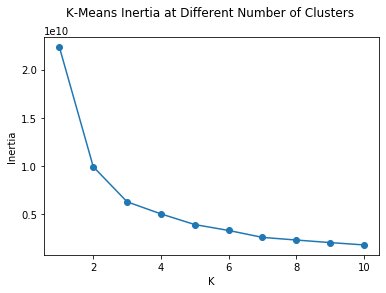

In [59]:
# Let's use different K for K-Means and generate a graph of inertia
sse = []
k_clusters = list(range(1,11))

for cluster in k_clusters:
    kmeans = KMeans(n_clusters=cluster, random_state=0).fit(X)
    sse.append(kmeans.inertia_)

plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('K-Means Inertia at Different Number of Clusters \n')
plt.plot(k_clusters, sse, '-o')

Reading the above chart, we can see that the elbow is at 3.

In [60]:
# set number of clusters
kclusters = 3

# cluster using K-Means algorithm
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)
kmeans.labels_[0:10]

array([2, 0, 2, 2, 1, 1, 1, 1, 2, 2], dtype=int32)

In [61]:
# Insert K-Means labels to df_merged
df_merged.insert(0, 'Cluster Labels', kmeans.labels_)
df_merged.head()

,Cluster Labels,Community Area Name,Neighborhood,Latitude,Longitude,Population,Area (Sq./Mile),Population Density (Sq./Mile),Per Capita Income,Count of Crimes,Count of Restaurants,Count of Parkings
Community Area Number,,,,,,,,,,,,
1,2,Rogers Park,"Loyola, Rogers Park",42.010531,-87.670748,55062,1.84,29925.00,23939,4035,10.0,18.0
2,0,West Ridge,"Nortown, Peterson Park, Rosehill, West Ridge, ...",42.003548,-87.696243,76215,3.53,21590.65,23040,3441,17.0,2.0
3,2,Uptown,"Buena Park, Clarendon Park, Margate Park, New ...",41.966630,-87.655546,57973,2.32,24988.36,35787,3339,27.0,14.0
4,2,Lincoln Square,"Bowmanville, Budlong Woods, Lincoln Square, Ra...",41.975990,-87.689616,41715,2.56,16294.92,37524,1793,15.0,2.0
5,1,North Center,"North Center, Roscoe Village, Saint Ben's",41.956107,-87.679160,35789,2.05,17458.05,57123,1270,14.0,5.0


### 3. Visualize the clusters using folium map

In [62]:
# Get Chicago latitude and longitude
geolocator = Nominatim(user_agent='my_agent')
chicago = geolocator.geocode('Chicago, USA')

# create map of Chicago
map_clusters = folium.Map(location=[chicago.latitude, chicago.longitude], zoom_start=11)

palette = ['#3498DB', '#FF0000', '#F1C40F']

# add markers to the map
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Community Area Name'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=palette[cluster],
        fill=True,
        fill_color=palette[cluster],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

### 4. Examine Clusters Using Box and Scatter Plots

Let's analyze the clusters using boxplots of each feature of the clusters. 

In [63]:
# Set boxplot properties
boxprops = dict(linestyle='-', linewidth=1.5, color='#1EAB22')
flierprops = dict(marker='o', markersize=4, linestyle='none')
whiskerprops = dict(color='#1EAB22', linewidth=1.5)
capprops = dict(color='#1EAB22')
medianprops = dict(linewidth=1.5, linestyle='-', color='#D35400')

# Create groups of clusters
group_clusters = df_merged.groupby('Cluster Labels')

#### 4.1 Boxplot of Population Density (Sq./Mile)

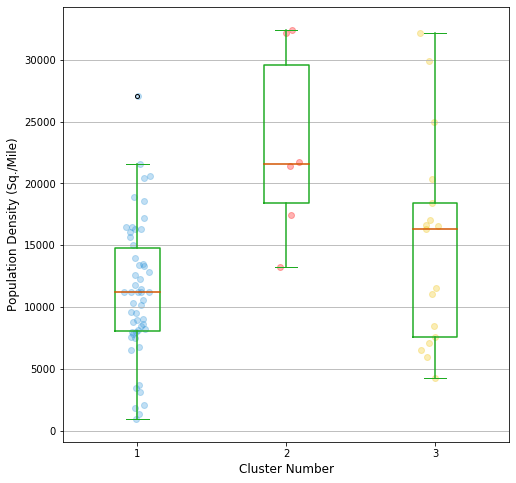

In [65]:
plt.figure(figsize=(8,8))

# Create list of values of Population Density (Sq./Mile) for each cluster
group_0 = group_clusters.get_group(0)['Population Density (Sq./Mile)'].values
group_1 = group_clusters.get_group(1)['Population Density (Sq./Mile)'].values
group_2 = group_clusters.get_group(2)['Population Density (Sq./Mile)'].values
x = [group_0, group_1, group_2]

plt.boxplot(x, notch=False, boxprops=boxprops,flierprops=flierprops, whiskerprops=whiskerprops, capprops=capprops,  medianprops=medianprops)

# Create a list of x axis with jitters for ploting a scattergraph of the data points
xs = []
for i in range(len(x)):
    xs.append(np.random.normal(i + 1, 0.04, len(x[i])))

# Define color palette for scatter graph data points
palette = ['#3498DB', '#FF0000', '#F1C40F']

# Creat scatter graph of each cluster
for x, val, c in zip(xs, x, palette):
    plt.scatter(x, val, alpha=0.3, color=c)

# Add horizontal gridlines to the plot
axes = plt.gca()
axes.yaxis.grid()

plt.xlabel('Cluster Number', fontsize=12)
plt.ylabel('Population Density (Sq./Mile)', fontsize=12)
plt.show()

#### 4.2 Boxplot of Per Capita Income

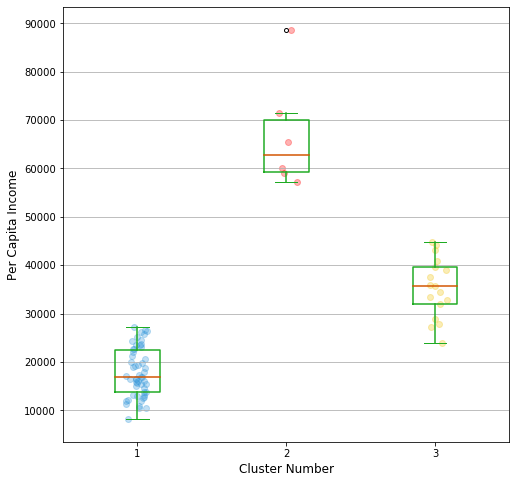

In [66]:
plt.figure(figsize=(8,8))

# Create list of values of Per Capita Income for each cluster
group_0 = group_clusters.get_group(0)['Per Capita Income'].values
group_1 = group_clusters.get_group(1)['Per Capita Income'].values
group_2 = group_clusters.get_group(2)['Per Capita Income'].values
x = [group_0, group_1, group_2]

plt.boxplot(x, notch=False, boxprops=boxprops,flierprops=flierprops, whiskerprops=whiskerprops, capprops=capprops,  medianprops=medianprops)

# Create a list of x axis with jitters for ploting a scattergraph of the data points
xs = []
for i in range(len(x)):
    xs.append(np.random.normal(i + 1, 0.04, len(x[i])))

# Define color palette for scatter graph data points
palette = ['#3498DB', '#FF0000', '#F1C40F']

# Creat scatter graph of each cluster
for x, val, c in zip(xs, x, palette):
    plt.scatter(x, val, alpha=0.3, color=c)

# Add horizontal gridlines to the plot
axes = plt.gca()
axes.yaxis.grid()

plt.xlabel('Cluster Number', fontsize=12)
plt.ylabel('Per Capita Income', fontsize=12)
plt.show()

#### 4.3 Boxplot of Count of Crimes

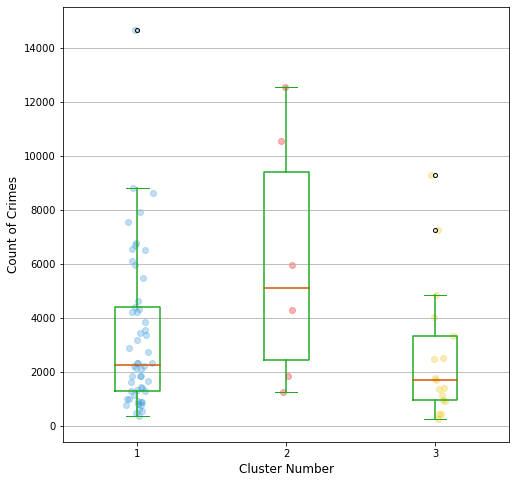

In [68]:
plt.figure(figsize=(8,8))

# Create list of values of Count of Crimes for each cluster
group_0 = group_clusters.get_group(0)['Count of Crimes'].values
group_1 = group_clusters.get_group(1)['Count of Crimes'].values
group_2 = group_clusters.get_group(2)['Count of Crimes'].values
x = [group_0, group_1, group_2]

plt.boxplot(x, notch=False, boxprops=boxprops,flierprops=flierprops, whiskerprops=whiskerprops, capprops=capprops,  medianprops=medianprops)

# Create a list of x axis with jitters for ploting a scattergraph of the data points
xs = []
for i in range(len(x)):
    xs.append(np.random.normal(i + 1, 0.04, len(x[i])))

# Define color palette for scatter graph data points
palette = ['#3498DB', '#FF0000', '#F1C40F']

# Creat scatter graph of each cluster
for x, val, c in zip(xs, x, palette):
    plt.scatter(x, val, alpha=0.3, color=c)

# Add horizontal gridlines to the plot
axes = plt.gca()
axes.yaxis.grid()

plt.xlabel('Cluster Number', fontsize=12)
plt.ylabel('Count of Crimes', fontsize=12)
plt.show()

#### 4.4 Boxplot of Count of Restaurants

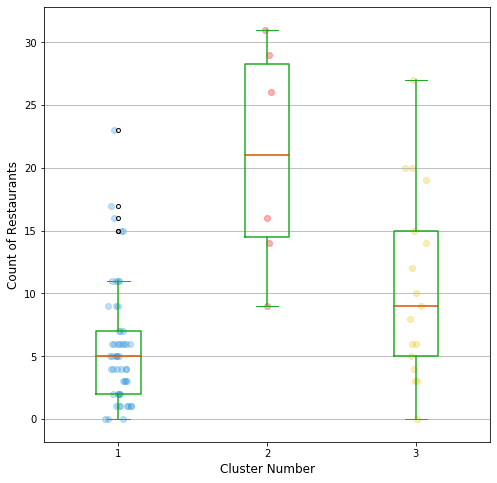

In [69]:
plt.figure(figsize=(8,8))

# Create list of values of Count of Restaurants for each cluster
group_0 = group_clusters.get_group(0)['Count of Restaurants'].values
group_1 = group_clusters.get_group(1)['Count of Restaurants'].values
group_2 = group_clusters.get_group(2)['Count of Restaurants'].values
x = [group_0, group_1, group_2]

plt.boxplot(x, notch=False, boxprops=boxprops,flierprops=flierprops, whiskerprops=whiskerprops, capprops=capprops,  medianprops=medianprops)

# Create a list of x axis with jitters for ploting a scattergraph of the data points
xs = []
for i in range(len(x)):
    xs.append(np.random.normal(i + 1, 0.04, len(x[i])))

# Define color palette for scatter graph data points
palette = ['#3498DB', '#FF0000', '#F1C40F']

# Creat scatter graph of each cluster
for x, val, c in zip(xs, x, palette):
    plt.scatter(x, val, alpha=0.3, color=c)

# Add horizontal gridlines to the plot
axes = plt.gca()
axes.yaxis.grid()

plt.xlabel('Cluster Number', fontsize=12)
plt.ylabel('Count of Restaurants', fontsize=12)
plt.show()

#### 4.5 Boxplot of Count of Parkings

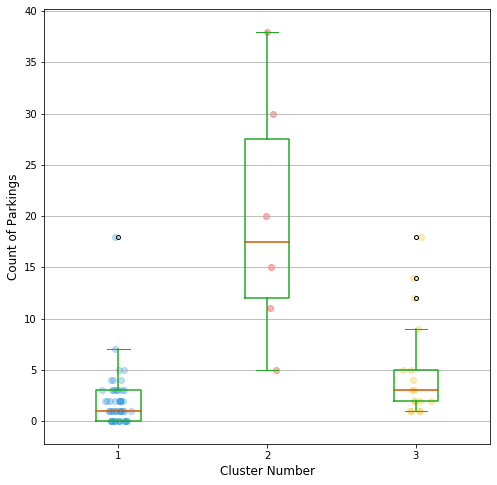

In [70]:
plt.figure(figsize=(8,8))

# Create list of values of Count of Parkings for each cluster
group_0 = group_clusters.get_group(0)['Count of Parkings'].values
group_1 = group_clusters.get_group(1)['Count of Parkings'].values
group_2 = group_clusters.get_group(2)['Count of Parkings'].values
x = [group_0, group_1, group_2]

plt.boxplot(x, notch=False, boxprops=boxprops,flierprops=flierprops, whiskerprops=whiskerprops, capprops=capprops,  medianprops=medianprops)

# Create a list of x axis with jitters for ploting a scattergraph of the data points
xs = []
for i in range(len(x)):
    xs.append(np.random.normal(i + 1, 0.04, len(x[i])))

# Define color palette for scatter graph data points
palette = ['#3498DB', '#FF0000', '#F1C40F']

# Creat scatter graph of each cluster
for x, val, c in zip(xs, x, palette):
    plt.scatter(x, val, alpha=0.3, color=c)

# Add horizontal gridlines to the plot
axes = plt.gca()
axes.yaxis.grid()

plt.xlabel('Cluster Number', fontsize=12)
plt.ylabel('Count of Parkings', fontsize=12)
plt.show()

Thank you!